<a href="https://colab.research.google.com/github/gfelekis/MSc-Dissertation/blob/master/GVI_FINAL_NOTEBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
!pip install GPy

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import urllib.request
import GPy
import os
import time
import copy
import math
import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [ ]:
#@title UCI Datasets
#Boston housing dataset
np.random.seed(2)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data1 = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data1 = data1[np.random.permutation(np.arange(len(data1)))]

# Concrete compressive dataset
np.random.seed(2)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data2 = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data2 = data2[np.random.permutation(np.arange(len(data2)))]

# Energy efficiency dataset
np.random.seed(2)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data3 = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data3 = data3[np.random.permutation(np.arange(len(data3)))]

# Red wine dataset
np.random.seed(2)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data4 = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data4 = data4[np.random.permutation(np.arange(len(data4)))]

#Yacht dataset
np.random.seed(2)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data5 = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data5 = data5[np.random.permutation(np.arange(len(data5)))]

In [3]:
torch.cuda.manual_seed_all(999)

In [4]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [5]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)

class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [6]:
def tensorize(x,y):
  """ Verifies both x and y are tensors. """
  if isinstance(x, int) and not isinstance(y, int):
    x = x * torch.ones_like(y)
  elif isinstance(y, int) and not isinstance(x, int):
    y = y * torch.ones_like(x)
  return x,y

In [7]:
class BayesLinear_Normalq(nn.Module):
  
    def __init__(self, input_dim, output_dim, prior, loss_type = "A", alpha=1.0):
        super(BayesLinear_Normalq, self).__init__()
        torch.manual_seed(42)
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.prior      = prior
        # redirect HEL and PEAR loss types to A loss and state the correct alpha
        if loss_type == "HEL":
          self.loss_type, self.alpha  = "A", 0.5
        elif loss_type == "PEAR":
          self.loss_type, self.alpha  = "A", 2.0
        else:
          self.loss_type  = loss_type
          self.alpha      = alpha
        
        #  Initialize neural network's parameters
        self.weight_mus  = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-4, -3)) #(-3,-3)
        
        self.bias_mus  = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons   =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_()) 
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos)) #softplus func
            bias_stds   = torch.log(1 + torch.exp(self.bias_rhos))   #softplus func
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample   = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the Divergence loss term

            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2

            #############
            # **0.5 is used wherever the torch.sqrt can't work since 
            # the value is not a torch.tensor
            ############

            # Kullback–Leibler Divergence
            if self.loss_type == "KL":
                loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
                loss = loss + 0.5*(varpost_cov/prior_cov).sum()
                loss = loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            # Reverse Kullback–Leibler Divergence
            elif self.loss_type == "RKL":
                loss = 0.5*(torch.log(varpost_cov/prior_cov)).sum() - 0.5*weight_stds.numel()
                loss = loss + 0.5*(prior_cov/varpost_cov).sum()
                loss = loss + 0.5*((self.prior.mu - self.weight_mus)**2/varpost_cov).sum()

            # Alpha-Renyi Divergence
            elif self.loss_type == "AR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                          (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() + \
                          0.5*(self.alpha*(self.weight_mus - self.prior.mu)**2/sigma_2).sum()
            
            # alpha-Alpha-Renyi Divergence
            elif self.loss_type == "aAR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = self.alpha*torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                          (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() + \
                          0.5*(self.alpha*(self.weight_mus - self.prior.mu)**2/sigma_2).sum()
            
            # Alpha Divergence
            elif self.loss_type == "A":
                frac = ((prior_cov**0.5)**self.alpha)*(torch.sqrt(varpost_cov)**(1-self.alpha)) \
                       /torch.sqrt(self.alpha*prior_cov + (1-self.alpha)*varpost_cov)
                exp  = torch.exp(-(self.alpha*(1-self.alpha)) * 0.5*(self.weight_mus-self.prior.mu)**2 / \
                                 (self.alpha*prior_cov + (1-self.alpha)*varpost_cov))
                loss = 1/(self.alpha*(1-self.alpha))*(1-frac*exp).sum()

            # Hellinger Distance 
            elif self.loss_type == "HEL":
                # this one is redirected at layer declaration to loss_type="A", alpha=0.5
                pass
            
            # Pearson Divergence
            elif self.loss_type == "PEAR":
                # this one is redirected at layer declaration to loss_type="A", alpha=2.0
                pass
            
            # Fisher Distance 
            elif self.loss_type == "F":
                fisher = torch.sqrt(((self.weight_mus-self.prior.mu)**2 \
                                     +2*(torch.sqrt(varpost_cov)-(prior_cov**0.5))**2)*((self.weight_mus-self.prior.mu)**2 \
                                      +2*(torch.sqrt(varpost_cov)+(prior_cov**0.5))**2))
                loss   = (2**0.5)*torch.log(fisher+(self.weight_mus-self.prior.mu)**2 \
                                        + 2*(varpost_cov + prior_cov)/(4*torch.sqrt(varpost_cov)*(prior_cov**0.5))).sum()
            
            # Jensen-Shannon Divergence
            elif self.loss_type == "JS":
                m_cov = 0.25*(prior_cov + varpost_cov) 
                m_mu  = 0.5*(self.weight_mus + self.prior.mu) 

                kl_p  = 0.5*(torch.log(prior_cov/m_cov)).sum() - 0.5*m_cov.numel()
                kl_p = kl_p + 0.5*(m_cov/prior_cov).sum()
                kl_p = kl_p + 0.5*((m_mu - self.prior.mu)**2/prior_cov).sum()

                kl_q  = 0.5*(torch.log(varpost_cov/m_cov)).sum() - 0.5*weight_stds.numel()
                kl_q = kl_q + 0.5*(m_cov/varpost_cov).sum()
                kl_q = kl_q + 0.5*((m_mu - self.weight_mus)**2/varpost_cov).sum()

                loss = 0.5*(kl_p + kl_q)
              
            # Total Variation Distance - lower bound
            elif self.loss_type == "TVL":
                torch_max = lambda x,y: torch.max(torch.stack(tensorize(x,y), dim=0))
                torch_min = lambda x,y: torch.min(torch.stack(tensorize(x,y), dim=0))

                loss = (1/200)*torch_min(1, torch_max(torch.abs(prior_cov-varpost_cov)/prior_cov, 
                                                       40*torch.abs(self.weight_mus-self.prior.mu)/prior_cov**0.5)).sum()
            # Total Variation Distance - upper bound
            elif self.loss_type == "TVU":
                loss = 3*(torch.abs(prior_cov-varpost_cov)/(2*prior_cov) + \
                      torch.abs(self.weight_mus-self.prior.mu)/2*prior_cov**0.5).sum()
                


            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2

            #Kullback–Leibler Divergence
            if self.loss_type == "KL":
                loss = loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
                loss = loss + 0.5*(varpost_cov/prior_cov).sum()
                loss = loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            #Reverse Kullback–Leibler Divergence
            elif self.loss_type == "RKL":
                loss = loss + 0.5*(torch.log(varpost_cov/prior_cov)).sum() - 0.5*bias_stds.numel()
                loss = loss + 0.5*(prior_cov/varpost_cov).sum()
                loss = loss + 0.5*((self.prior.mu - self.bias_mus)**2/varpost_cov).sum()

            #Alpha-Renyi Divergence
            elif self.loss_type == "AR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = loss + torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                                 (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() +  \
                                 0.5*(self.alpha*(self.bias_mus - self.prior.mu)**2/sigma_2).sum()

            #alpha-Alpha-Renyi Divergence
            elif self.loss_type == "aAR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = loss + self.alpha*torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                                 (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() +  \
                                 0.5*(self.alpha*(self.bias_mus - self.prior.mu)**2/sigma_2).sum()

            #Alpha Divergence
            elif self.loss_type == "A": 
                frac = ((prior_cov**0.5)**self.alpha)*(torch.sqrt(varpost_cov)**(1-self.alpha)) \
                       /torch.sqrt(self.alpha*prior_cov + (1-self.alpha)*varpost_cov)
                exp  = torch.exp(-(self.alpha*(1-self.alpha)) * 0.5*(self.bias_mus-self.prior.mu)**2 / \
                                 (self.alpha*prior_cov + (1-self.alpha)*varpost_cov))
                loss = loss + 1/(self.alpha*(1-self.alpha))*(1-frac*exp).sum()
            
            #Hellinger Distance 
            elif self.loss_type == "HEL":
                # this one is redirected at layer declaration to loss_type="A", alpha=0.5
                pass
            
            #Pearson Divergence
            elif self.loss_type == "PEAR":
                # this one is redirected at layer declaration to loss_type="A", alpha=2.0
                pass

            #Fisher Distance 
            elif self.loss_type == "F":
                fisher = torch.sqrt(((self.bias_mus-self.prior.mu)**2 \
                                     +2*(torch.sqrt(varpost_cov)-(prior_cov**0.5))**2)*((self.bias_mus-self.prior.mu)**2 \
                                      +2*(torch.sqrt(varpost_cov)+(prior_cov**0.5))**2))
                loss   = loss + (2**0.5)*torch.log(fisher+(self.bias_mus-self.prior.mu)**2 + \
                                            2*(varpost_cov + prior_cov)/(4*torch.sqrt(varpost_cov)*(prior_cov**0.5))).sum()
            
            #Jensen-Shannon Divergence
            elif self.loss_type == "JS":
                m_cov = 0.25*(prior_cov + varpost_cov) 
                m_mu  = 0.5*(self.bias_mus + self.prior.mu) 

                kl_p  = 0.5*(torch.log(prior_cov/m_cov)).sum() - 0.5*m_cov.numel()
                kl_p = kl_p + 0.5*(m_cov/prior_cov).sum()
                kl_p = kl_p + 0.5*((m_mu - self.prior.mu)**2/prior_cov).sum()

                kl_q  = 0.5*(torch.log(varpost_cov/m_cov)).sum() - 0.5*weight_stds.numel()
                kl_q = kl_q + 0.5*(m_cov/varpost_cov).sum()
                kl_q = kl_q + 0.5*((m_mu - self.bias_mus)**2/varpost_cov).sum()

                loss = loss + 0.5*(kl_p + kl_q)

            # Total Variation Distance - lower bound
            elif self.loss_type == "TVL":
                loss = loss + (1/200)*torch_min(1, torch_max(torch.abs(prior_cov-varpost_cov)/prior_cov, 
                                                       40*torch.abs(self.bias_mus-self.prior.mu)/prior_cov**0.5)).sum()

            # Total Variation Distance - upper bound
            elif self.loss_type == "TVU":
                loss = loss + 3*(torch.abs(prior_cov-varpost_cov)/(2*prior_cov) +\
                                torch.abs(self.bias_mus-self.prior.mu)/2*prior_cov**0.5).sum()


            return output, loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, loss

In [8]:
class BBP_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units=[], loss_type="AR", alpha=1.0):
        super(BBP_Model_UCI, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.loss_type  = loss_type
        self.alpha      = alpha 
        self.num_units  = num_units
        
        # network with two hidden and one output layer
        if len(num_units) == 1:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], 2*output_dim, gaussian(0, 1), loss_type, alpha)
        if len(num_units) == 2:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 1), loss_type, alpha)
          self.layer3 = BayesLinear_Normalq(num_units[1], 2*output_dim, gaussian(0, 1), loss_type, alpha)
        elif len(num_units) == 3:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 1), loss_type, alpha)
          self.layer3 = BayesLinear_Normalq(num_units[1], num_units[2], gaussian(0, 1), loss_type, alpha)
          self.layer4 = BayesLinear_Normalq(num_units[2], 2*output_dim, gaussian(0, 1), loss_type, alpha)

        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, loss = self.layer1(x)
        loss_total = loss_total + loss
        x = self.activation(x)

        if len(self.num_units) == 1:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss

        if len(self.num_units) == 2:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer3(x)
          loss_total = loss_total + loss

        elif len(self.num_units) == 3:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer3(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer4(x)
          loss_total = loss_total + loss
        
        return x, loss_total

def train_BBP(data, n_splits, num_epochs, num_units, learn_rate, log_every, loss_type="AR", alpha=1.0):
    torch.manual_seed(42)
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []
    total_loss_accross_splits = []

    for i, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % i)
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        # Normilising the data
        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test  = (x_test - x_means)/x_stds
        y_test  = (y_test - y_means)/y_stds

        batch_size, nb_train = len(x_train), len(x_train)

        model = BBP_Model_UCI(x_test.shape[-1], output_dim=1, num_units=num_units, loss_type=loss_type, alpha=alpha)
        
        net   = BBP_Model_Wrapper(model, learn_rate=1e-2, batch_size=batch_size, no_batches=1)

        fit_loss_train = np.zeros(num_epochs)
        loss_train     = np.zeros(num_epochs)
        total_loss     = np.zeros(num_epochs)

        best_net, best_loss = None, float('inf')

        loss_evolution = []
        for i in range(num_epochs):
            fit_loss, loss, total_loss_record  = net.fit(x_train, y_train, no_samples = 100)
            fit_loss_train[i] += fit_loss.cpu().data.numpy()
            loss_train[i]     += loss.cpu().data.numpy()
            # record total loss for training curve display
            loss_evolution.append(total_loss_record)

            total_loss[i] = fit_loss_train[i] + loss_train[i]

            if fit_loss < best_loss:
                best_loss = fit_loss
                best_net  = copy.deepcopy(net.network)

            if i % log_every == 0 or i == num_epochs - 1:

                train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
                test_losses, test_rmse   = net.get_loss_and_rmse(x_test, y_test, 20)

                print('Epoch: %s/%d, Train loglik = %.3f, Test loglik = %.3f, Train RMSE = %.3f, Test RMSE = %.3f' %\
                      (str(i+1).zfill(3), num_epochs, -train_losses.mean() - np.log(y_stds)[0],
                       -test_losses.mean() - np.log(y_stds)[0], y_stds*train_rmse, y_stds*test_rmse))

        # record loss evlution
        total_loss_accross_splits.append(loss_evolution.copy())

        train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
        test_losses, test_rmse   = net.get_loss_and_rmse(x_test, y_test, 20)

        train_logliks.append((train_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))
        test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

        train_rmses.append(y_stds*train_rmse)
        test_rmses.append(y_stds*test_rmse)

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))

    rmses =  list(np.array(test_rmses).flatten())
    print("Test LogLike for different folds: ", test_logliks)
    print("Test RMSEs   for different folds: ", rmses)

    metrics = {"train_log_like_mean": -np.array(train_logliks).mean(), "train_log_like_var": np.array(train_logliks).var()**0.5,
               "test_log_like_mean": -np.array(test_logliks).mean(), "test_log_like_var": np.array(test_logliks).var()**0.5,
               "train_rmse_mean": np.array(train_rmses).mean(), "train_rmse_var": np.array(train_rmses).var()**0.5,
               "test_rmse_mean": np.array(test_rmses).mean(), "test_rmse_var":np.array(test_rmses).var()**0.5,
               "rmse_values": list(np.array(test_rmses).flatten()),
               "loglik_values": list(np.array(test_logliks).flatten()),
               "total_loss_accross_splits": list(np.array(total_loss_accross_splits).flatten())}

    return best_net, metrics

In [9]:
class BBP_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        torch.manual_seed(42)
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss       = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        loss_total = loss_total/self.no_batches # Divergence loss 
        total_loss = (fit_loss_total + loss_total)/(no_samples*x.shape[0])
        #total_loss = (fit_loss_total/no_samples + loss_total)/(x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, loss_total, total_loss.cpu().detach().numpy()
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, loss_total = self.network(x)
            means.append(output[:, :1, None]) 
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std  = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

In [10]:
class BBP_Model_Wrapper2:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss       = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        loss_total = loss_total/self.no_batches
        total_loss = (fit_loss_total + loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, loss_total
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std  = (means.var(dim=2) + stds.mean(dim=2)*2)*0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)*2).mean()*0.5).cpu().data)

        return logliks, rmse

## RUNNING THE EXPERIMENTS

# Regression on UCI data


In [ ]:
# set up the access to drive - we'll be saving our logs there
from google.colab import drive
drive.mount("/content/drive")
# define paths for the different experiments
alpha_path = "/content/drive/My Drive/"+"alpha_gridsearch_logs.txt"
grid_path  = "/content/drive/My Drive/"+"div_gridsearch_logs.txt"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Grid Search for Alpha and Alpha-Renyi divergences

In [ ]:
logs_alpha = []
### some params
n_splits = 30
n_epochs = 100
hidden   = 100
models, log_metrics = [], []

### alphas_experiment
losses  = ["A", "AR", "aAR"]
dataset = [data1, data2, data3, data4, data5] # list of all the datasets
dataset_names = ["Boston", "Concrete", "Energy", "Wine", "Yacht"]
alphas  = [0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0] 
hiddens = [1]
for loss in losses:
  print("Divergence ==", loss)
  for alpha in alphas:
    print("Alpha ==", alpha)
    i = 0
    for data in dataset:
      dataset_name = dataset_names[i]
      for h in hiddens:
        # run the training
        num_units = [hidden for i in range(h)]
        model, metric = train_BBP(data, n_splits=n_splits, num_epochs=n_epochs, num_units=num_units,
                                  learn_rate=1e-2, log_every=10, loss_type=loss, alpha=alpha)
        models.append(model)
        # record to file: 
        log = {"dataset": dataset_name,
               "loss": loss,
               "alpha": alpha,
               "n_layers": h, 
               "constant_hidden_size": hidden, 
               "metrics": metric}
        logs_alpha.append(log)
      i += 1
      with open(alpha_path, "a") as f:
          f.write(str(log)+"\n")
          print(log)

Test of the performance of different divergences - GVI Vs VI

In [ ]:
logs_grid = []
### some params
n_splits = 30
n_epochs = 100
hidden   = 100
### alphas_experiment
loss2alpha = {"A": 2.75, "AR": 2.0, "aAR": 2.5}
losses  = ["KL", "RKL", "JS", "F", "TVL", "TVU", "A", "AR", "aAR"]
dataset = [data2, data3, data5] # list of all the datasets
dataset_names = ["Concrete", "Energy", "Yacht"]
hiddens = [1, 2, 3]
models, log_metrics = [], []
for loss in losses:
  alpha = loss2alpha[loss] if loss in loss2alpha.keys() else 1.0
  print("Divergence ==", loss)
  i = 0
  for data in dataset:
    dataset_name = dataset_names[i]
    for h in hiddens:
      # run the training
      num_units = [hidden for i in range(h)]
      model, metric = train_BBP(data, n_splits=n_splits, num_epochs=n_epochs, num_units=num_units,
                                  learn_rate=1e-2, log_every=10, loss_type=loss, alpha=alpha)
      models.append(model)
      # record to file: 
      log = {"dataset": dataset_name,
             "loss": loss,
             "alpha": alpha,
             "n_layers": h, 
             "constant_hidden_size": hidden, 
             "metrics": metric}
      logs_grid.append(log)
      with open(grid_path, "a") as f:
        f.write(str(log)+"\n")
      print(log)
    i += 1


# Regression on GP ground truth






In [11]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units=[], loss_type="KL", alpha=1.0):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.loss_type  = loss_type
        self.alpha      = alpha 
        self.num_units  = num_units
        
        # network with two hidden and one output layer
        if len(num_units) == 1:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], 2*output_dim, gaussian(0, 1), loss_type, alpha)
        if len(num_units) == 2:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 1), loss_type, alpha)
          self.layer3 = BayesLinear_Normalq(num_units[1], 2*output_dim, gaussian(0, 1), loss_type, alpha)
        elif len(num_units) == 3:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 1), loss_type, alpha)
          self.layer3 = BayesLinear_Normalq(num_units[1], num_units[2], gaussian(0, 1), loss_type, alpha)
          self.layer4 = BayesLinear_Normalq(num_units[2], 2*output_dim, gaussian(0, 1), loss_type, alpha)

        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, loss = self.layer1(x)
        loss_total = loss_total + loss
        x = self.activation(x)

        if len(self.num_units) == 1:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss

        if len(self.num_units) == 2:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer3(x)
          loss_total = loss_total + loss

        elif len(self.num_units) == 3:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer3(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer4(x)
          loss_total = loss_total + loss
        
        return x, loss_total

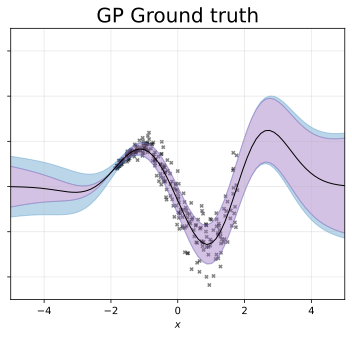

In [12]:
# Ground truth for data generated from an RBF kernel GP

np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x+2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

rbf = GPy.kern.MLP(input_dim=1, variance=1)#, lengthscale=1.)

mean = []
var = []
no_points = len(x_train)
all_x = np.linspace(-10, 10, 150)
for x in all_x:
    xs = np.array([[x] + list(x_train)]).T
    C = k.K(xs, xs)
    
    data_var = np.eye(no_points)*np.array((xs[1:]-2)**2*sig_noise**2).astype(float)
    pred_var = np.eye(1)*(xs[:1]+2)**2*sig_noise**2
    
    # print(data_var)
    # print(C[1:, 1:])
    mean.append(C[:1, 1:].dot(np.linalg.inv(np.array(C[1:, 1:] + data_var))).dot(y_train))
    var.append(C[:1, :1] + pred_var - C[:1, 1:].dot(np.linalg.inv(C[1:, 1:] + data_var)).dot(C[:1, 1:].T))

means = np.array(mean)[:, 0, 0]
var = np.array(var)[:, 0, 0]

aleatoric = abs(all_x+2)*sig_noise
total_unc = var**0.5
epistemic = (total_unc**2 - aleatoric**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(all_x.astype(float), (means + aleatoric).astype(float), (means + total_unc).astype(float), color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(all_x.astype(float), (means - total_unc).astype(float), (means - aleatoric).astype(float), color = c[0], alpha = 0.3)
plt.fill_between(all_x.astype(float), (means - aleatoric).astype(float), (means + aleatoric).astype(float), color = c[4], alpha = 0.4, label = 'Aleatoric')
plt.plot(all_x, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=10)
plt.title('GP Ground truth', fontsize=20)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('gp_hetero.pdf', bbox_inches = 'tight')

plt.show()

Plotting functions

In [13]:
def plot_uncertainty(net, x, y, std, mean, loss):
  samples, noises = [], []
  for i in range(100):
      preds = net.forward(torch.linspace(-5, 5, 200).cuda())[0]
      samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
      noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

  samples = np.array(samples)
  noises = np.array(noises)
  means = samples.mean(axis = 0)

  aleatoric = (noises**2).mean(axis = 0)**0.5
  epistemic = samples.var(axis = 0)**0.5
  aleatoric = np.minimum(aleatoric, 10e3)
  epistemic = np.minimum(epistemic, 10e3)

  total_unc = (aleatoric**2 + epistemic**2)**0.5

  c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

  x_mean, x_std = x_train.mean(), x_train.var()**0.5
  plt.figure(figsize = (5, 4))
  plt.style.use('default')
  plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
  plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
  plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
  plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[4], alpha = 0.4, label = 'Aleatoric')
  plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
  plt.xlim([-5, 5])
  plt.ylim([-5, 7])
  plt.xlabel('$x$', fontsize=10)
  plt.title(str(loss), fontsize=20)
  plt.tick_params(labelsize=10)
  plt.xticks(np.arange(-4, 5, 2))
  plt.yticks(np.arange(-4, 7, 2))
  plt.gca().set_yticklabels([])
  plt.gca().yaxis.grid(alpha=0.3)
  plt.gca().xaxis.grid(alpha=0.3)
  plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')


  plt.show()

In [14]:
def plot_uncertainty_3row(nets, x, y, std, mean, loss):
  fig, ax = plt.subplots(1, 3, figsize=(15, 4))
  fig.suptitle(loss + " h=1 | h=2 | h=3")
  for n, net in enumerate(nets):
    samples, noises = [], []
    for i in range(100):
        preds = nets[n].network.forward(torch.linspace(-5, 5, 200).cuda())[0]
        samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
        noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

    samples = np.array(samples)
    noises = np.array(noises)
    means = samples.mean(axis = 0)

    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = samples.var(axis = 0)**0.5
    aleatoric = np.minimum(aleatoric, 10e3)
    epistemic = np.minimum(epistemic, 10e3)

    total_unc = (aleatoric**2 + epistemic**2)**0.5

    def perc_in_between(mus, uncerts, array, k=1):
      print(mus.shape, uncerts.shape, array.shape)
      overlaps = []
      for i in range(len(mus)):
        sample_data = np.random.normal(array[i, 0], np.abs(array[i, 1]), 250)
        below_upper  = (array * std + mean) < (mus[i] + uncerts[i]*k)
        above_lower  = (array * std + mean) > (mus[i] - uncerts[i]*k)
        overlaps.append(np.mean(np.logical_and(below_upper, above_lower)))
      return np.mean(overlaps)

    def perc_in_between_v2(mus, uncerts, array, k=1):
      bound1 = array[:, 0] + k*array[:, 1]
      bound2 = array[:, 0] - k*array[:, 1]
      upper_pred_bound  = np.maximum(bound1, bound2)
      lower_pred_bound  = np.minimum(bound1, bound2)
      in_between = np.logical_and(mus<upper_pred_bound, mus>lower_pred_bound)
      return np.mean(in_between)

    check_points = {0.05: 0.039878, 0.2: 0.15852, 0.33: 0.25, 0.5: 0.38292, 1: 0.68, 2: 0.95, 3: 0.99}
    print("Calculating %_in_between for network =", n)
    values       = []
    for k,v in check_points.items():
      values.append(perc_in_between_v2(means, total_unc, preds.cpu().detach().numpy(), k=k))
      print(k, "sigma(s) -> Expected:", v, "and got", values[-1])
    print("(sigma, expected):", check_points)
    print("(sigma, got):", {k:v for k,v in zip(check_points.keys(), values)})

    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    x_mean, x_std = x_train.mean(), x_train.var()**0.5
    ax[n].scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
    ax[n].fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
    ax[n].fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    ax[n].fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[4], alpha = 0.4, label = 'Aleatoric')
    ax[n].plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
    ax[n].set_xlim([-5, 5])
    ax[n].set_ylim([-5, 7])
    ax[n].set_xlabel('$x$', fontsize=10)
    ax[n].set_title("h = "+str(n+1), fontsize=10)
    ax[n].tick_params(labelsize=10)
    ax[n].set_xticks(np.arange(-4, 5, 2))
    ax[n].set_yticks(np.arange(-4, 7, 2))
    plt.gca().set_yticklabels([])
    ax[n].grid(alpha=0.3)

  plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')
  plt.show()

Information Criteria for Model selection


In [15]:
# Akaike’s Information Criterion
def aic(y, y_pred, p):
    n = len(y)
    resid = np.subtract(y_pred, y)
    rss = np.sum(np.power(resid, 2))
    aic_score = n*np.log(rss/n) + 2*p
    return aic_score

# Bayesian Information Criterion
def bic(y, y_pred, p):
    n = len(y)
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    bic_score = n*np.log(SSE/n) + p*np.log(n)
    return bic_score

# Hannan–Quinn Information Criterion
def hqc(y, y_pred, p):
    n = len(y)
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    hqc_score = n*np.log(SSE/n) + 2*p*np.log(np.log(n))
    return hqc_score

# Log-likelihood Information Criterion
def llc(y, y_pred):
    n = len(y)
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    llc_score = n*np.log(SSE/n) 
    return llc_score

Regression on heteroscedastic data

Epoch: 1/500, Fit loss = 355.3716735839844, KL loss = 1227.7490234375
Epoch: 101/500, Fit loss = 64.90131378173828, KL loss = 1136.7144775390625
Epoch: 201/500, Fit loss = 33.110042572021484, KL loss = 1157.0247802734375
Epoch: 301/500, Fit loss = 27.414627075195312, KL loss = 1164.5244140625
Epoch: 401/500, Fit loss = 21.866899490356445, KL loss = 1161.8719482421875
Epoch: 500/500, Fit loss = 14.429614067077637, KL loss = 1148.242431640625
Train RMSE =  -0.03313126042485237
Train Log-likelihood =  0.5287108679796556
Epoch: 1/500, Fit loss = 355.1831359863281, KL loss = 62688.96875
Epoch: 101/500, Fit loss = 71.42447662353516, KL loss = 43435.89453125
Epoch: 201/500, Fit loss = 73.98485565185547, KL loss = 26724.955078125
Epoch: 301/500, Fit loss = 51.336517333984375, KL loss = 13931.806640625
Epoch: 401/500, Fit loss = 32.87789535522461, KL loss = 6722.626953125
Epoch: 500/500, Fit loss = 28.094043731689453, KL loss = 3852.7568359375
Train RMSE =  0.005610288120806217
Train Log-likeli

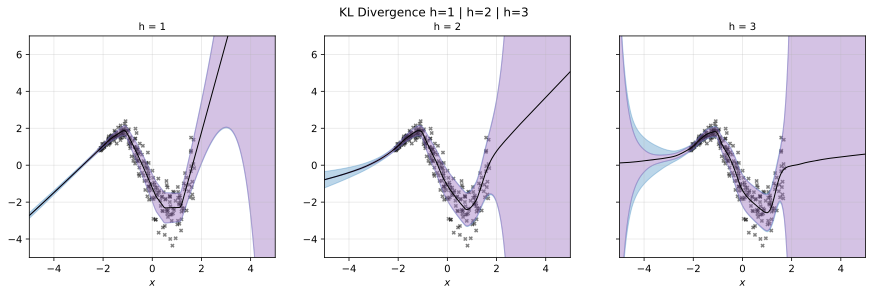

AIC for layers = 1 is: 1135.1508948584083
BIC for layers = 1 is: 3966.405472819654
HQC for layers = 1 is: 2274.6480096224495
LLC for layers = 1 is: -472.8491051415917

AIC for layers = 2 is: 82704.29705372141
BIC for layers = 2 is: 229211.1570804623
HQC for layers = 2 is: 141669.0208878547
LLC for layers = 2 is: -503.7029462785847

AIC for layers = 3 is: 162304.71990555935
BIC for layers = 3 is: 448965.7244632176
HQC for layers = 3 is: 277677.3854904499
LLC for layers = 3 is: -503.2800944406504

Epoch: 1/500, Fit loss = 355.3716735839844, RKL loss = 284468.875
Epoch: 101/500, Fit loss = 191.0924835205078, RKL loss = 66110.3984375
Epoch: 201/500, Fit loss = 165.82904052734375, RKL loss = 31412.53515625
Epoch: 301/500, Fit loss = 166.17605590820312, RKL loss = 19151.009765625
Epoch: 401/500, Fit loss = 169.6446075439453, RKL loss = 13403.140625
Epoch: 500/500, Fit loss = 136.5970001220703, RKL loss = 10159.84375
Train RMSE =  -0.008320054970681667
Train Log-likelihood =  0.91694203554941

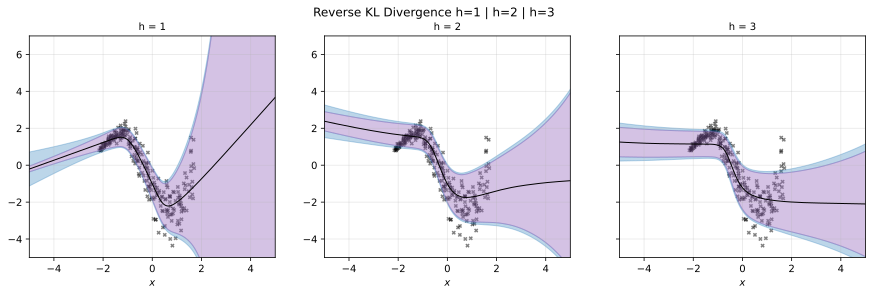

AIC for layers = 1 is: 1251.0259924347265
BIC for layers = 1 is: 4082.280570395972
HQC for layers = 1 is: 2390.523107198768
LLC for layers = 1 is: -356.97400756527344

AIC for layers = 2 is: 82983.23282863696
BIC for layers = 2 is: 229490.09285537785
HQC for layers = 2 is: 141947.95666277027
LLC for layers = 2 is: -224.76717136303526

AIC for layers = 3 is: 162474.07307106088
BIC for layers = 3 is: 449135.07762871915
HQC for layers = 3 is: 277846.73865595146
LLC for layers = 3 is: -333.9269289391295

Epoch: 1/500, Fit loss = 355.3716735839844, JS loss = 35126.2578125
Epoch: 101/500, Fit loss = 125.477294921875, JS loss = 8306.6611328125
Epoch: 201/500, Fit loss = 103.45279693603516, JS loss = 4193.2744140625
Epoch: 301/500, Fit loss = 118.5379867553711, JS loss = 2830.66162109375
Epoch: 401/500, Fit loss = 124.17806243896484, JS loss = 2247.774169921875
Epoch: 500/500, Fit loss = 94.4413070678711, JS loss = 1928.387939453125
Train RMSE =  0.06469519436359406
Train Log-likelihood =  0.7

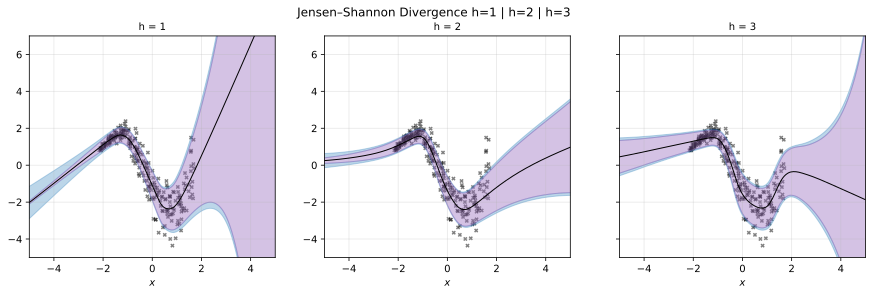

AIC for layers = 1 is: 1250.6730250027315
BIC for layers = 1 is: 4081.927602963977
HQC for layers = 1 is: 2390.170139766773
LLC for layers = 1 is: -357.3269749972685

AIC for layers = 2 is: 82727.17848774877
BIC for layers = 2 is: 229234.03851448963
HQC for layers = 2 is: 141691.90232188205
LLC for layers = 2 is: -480.8215122512369

AIC for layers = 3 is: 162400.86989810853
BIC for layers = 3 is: 449061.8744557668
HQC for layers = 3 is: 277773.5354829991
LLC for layers = 3 is: -407.13010189145456

Epoch: 1/500, Fit loss = 355.3716735839844, TVL loss = 0.019990401342511177
Epoch: 101/500, Fit loss = 55.48073959350586, TVL loss = 0.019999999552965164
Epoch: 201/500, Fit loss = 22.37080955505371, TVL loss = 0.019999999552965164
Epoch: 301/500, Fit loss = 12.247431755065918, TVL loss = 0.019999999552965164
Epoch: 401/500, Fit loss = 11.033792495727539, TVL loss = 0.019999999552965164
Epoch: 500/500, Fit loss = 6.455148220062256, TVL loss = 0.019999999552965164
Train RMSE =  0.0038627847097

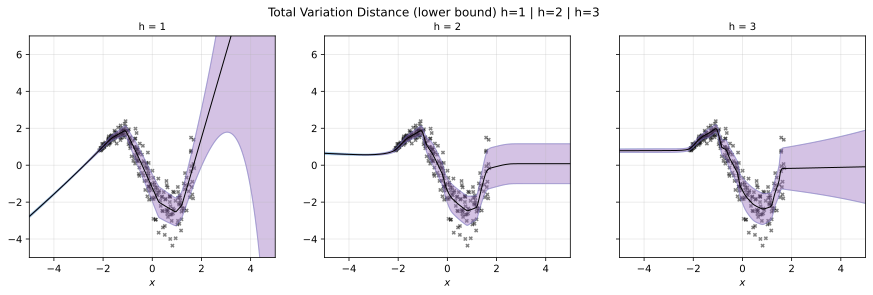

AIC for layers = 1 is: 1108.8150609613567
BIC for layers = 1 is: 3940.0696389226023
HQC for layers = 1 is: 2248.312175725398
LLC for layers = 1 is: -499.18493903864317

AIC for layers = 2 is: 82703.44839963631
BIC for layers = 2 is: 229210.3084263772
HQC for layers = 2 is: 141668.1722337696
LLC for layers = 2 is: -504.55160036368187

AIC for layers = 3 is: 162305.26387804002
BIC for layers = 3 is: 448966.2684356983
HQC for layers = 3 is: 277677.9294629306
LLC for layers = 3 is: -502.73612195998

Epoch: 1/500, Fit loss = 355.3716735839844, TVU loss = 605.5392456054688
Epoch: 101/500, Fit loss = 52.96949005126953, TVU loss = 698.033203125
Epoch: 201/500, Fit loss = 30.04911231994629, TVU loss = 706.2167358398438
Epoch: 301/500, Fit loss = 13.857266426086426, TVU loss = 711.6627197265625
Epoch: 401/500, Fit loss = 11.60952377319336, TVU loss = 712.8668212890625
Epoch: 500/500, Fit loss = 10.082625389099121, TVU loss = 712.5406494140625
Train RMSE =  -0.009185113944113255
Train Log-likelih

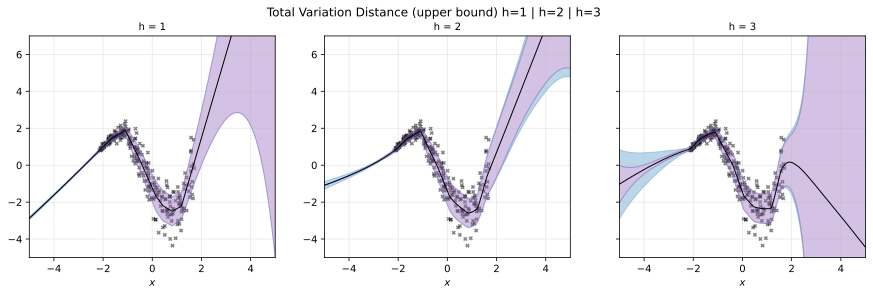

AIC for layers = 1 is: 1105.3139055232596
BIC for layers = 1 is: 3936.568483484505
HQC for layers = 1 is: 2244.811020287301
LLC for layers = 1 is: -502.6860944767404

AIC for layers = 2 is: 82701.9747773419
BIC for layers = 2 is: 229208.83480408275
HQC for layers = 2 is: 141666.69861147518
LLC for layers = 2 is: -506.02522265811035

AIC for layers = 3 is: 162303.3916279725
BIC for layers = 3 is: 448964.3961856308
HQC for layers = 3 is: 277676.0572128631
LLC for layers = 3 is: -504.6083720274861

Epoch: 1/500, Fit loss = 355.3716735839844, F loss = 1690.42626953125
Epoch: 101/500, Fit loss = 67.40204620361328, F loss = 1543.473388671875
Epoch: 201/500, Fit loss = 33.35415267944336, F loss = 1562.833251953125
Epoch: 301/500, Fit loss = 30.9322452545166, F loss = 1573.7188720703125
Epoch: 401/500, Fit loss = 28.802343368530273, F loss = 1572.2109375
Epoch: 500/500, Fit loss = 20.742387771606445, F loss = 1557.994873046875
Train RMSE =  -0.005803836043924093
Train Log-likelihood =  0.52983

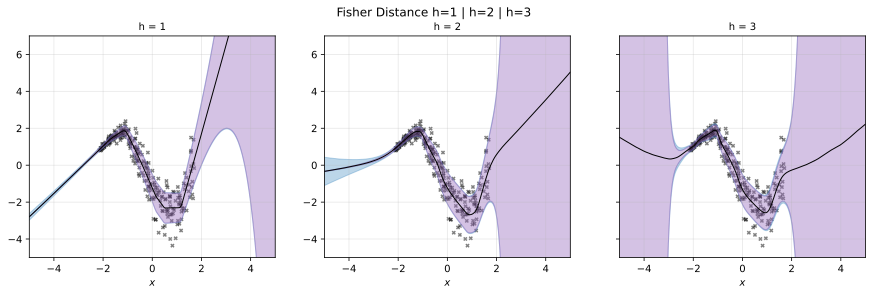

AIC for layers = 1 is: 1131.4767904556518
BIC for layers = 1 is: 3962.731368416897
HQC for layers = 1 is: 2270.973905219693
LLC for layers = 1 is: -476.5232095443483

AIC for layers = 2 is: 82704.52726142359
BIC for layers = 2 is: 229211.38728816446
HQC for layers = 2 is: 141669.2510955569
LLC for layers = 2 is: -503.47273857641386

AIC for layers = 3 is: 162305.9116434315
BIC for layers = 3 is: 448966.9162010898
HQC for layers = 3 is: 277678.5772283221
LLC for layers = 3 is: -502.0883565685059

Epoch: 1/500, Fit loss = 355.3716735839844, A loss = 28406.5625
Epoch: 101/500, Fit loss = 120.00841522216797, A loss = 8037.861328125
Epoch: 201/500, Fit loss = 107.9903564453125, A loss = 4389.736328125
Epoch: 301/500, Fit loss = 121.32453918457031, A loss = 3152.5234375
Epoch: 401/500, Fit loss = 125.10936737060547, A loss = 2620.529541015625
Epoch: 500/500, Fit loss = 92.29142761230469, A loss = 2331.366943359375
Train RMSE =  0.015013586729764938
Train Log-likelihood =  0.7261507564718822


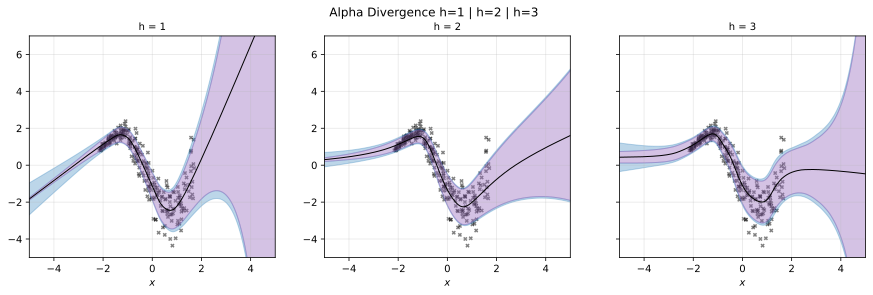

AIC for layers = 1 is: 1274.0183960271036
BIC for layers = 1 is: 4105.272973988349
HQC for layers = 1 is: 2413.515510791145
LLC for layers = 1 is: -333.98160397289644

AIC for layers = 2 is: 82748.23860848298
BIC for layers = 2 is: 229255.09863522384
HQC for layers = 2 is: 141712.96244261626
LLC for layers = 2 is: -459.76139151702614

AIC for layers = 3 is: 162472.13383048517
BIC for layers = 3 is: 449133.13838814344
HQC for layers = 3 is: 277844.79941537575
LLC for layers = 3 is: -335.8661695148428

Epoch: 1/500, Fit loss = 355.3716735839844, AR loss = 1289.32958984375
Epoch: 101/500, Fit loss = 64.93060302734375, AR loss = 1198.1123046875
Epoch: 201/500, Fit loss = 33.47394561767578, AR loss = 1217.692626953125
Epoch: 301/500, Fit loss = 27.17725944519043, AR loss = 1225.4334716796875
Epoch: 401/500, Fit loss = 22.259336471557617, AR loss = 1222.06494140625
Epoch: 500/500, Fit loss = 13.57774543762207, AR loss = 1207.7850341796875
Train RMSE =  -0.034103166311979294
Train Log-likelih

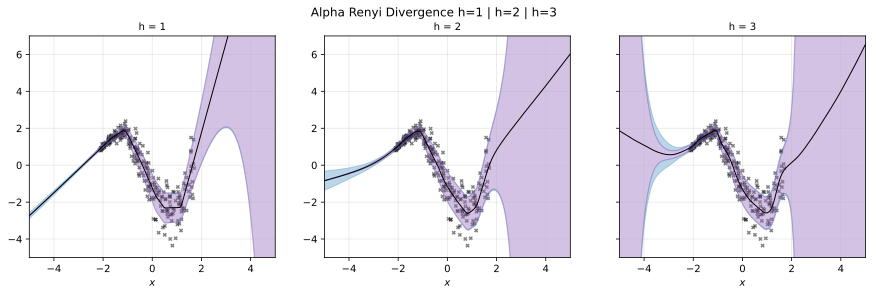

AIC for layers = 1 is: 1133.9356568972983
BIC for layers = 1 is: 3965.1902348585436
HQC for layers = 1 is: 2273.4327716613393
LLC for layers = 1 is: -474.0643431027018

AIC for layers = 2 is: 82704.1459951809
BIC for layers = 2 is: 229211.00602192176
HQC for layers = 2 is: 141668.86982931418
LLC for layers = 2 is: -503.85400481910733

AIC for layers = 3 is: 162304.8034081084
BIC for layers = 3 is: 448965.80796576664
HQC for layers = 3 is: 277677.46899299894
LLC for layers = 3 is: -503.19659189161547

Epoch: 1/500, Fit loss = 355.3716735839844, aAR loss = 3448.67236328125
Epoch: 101/500, Fit loss = 99.98431396484375, aAR loss = 2948.05908203125
Epoch: 201/500, Fit loss = 45.29765701293945, aAR loss = 2867.235595703125
Epoch: 301/500, Fit loss = 40.032135009765625, aAR loss = 2805.48046875
Epoch: 401/500, Fit loss = 37.078369140625, aAR loss = 2734.153564453125
Epoch: 500/500, Fit loss = 32.867027282714844, aAR loss = 2649.145751953125
Train RMSE =  0.039822082966566086
Train Log-likelih

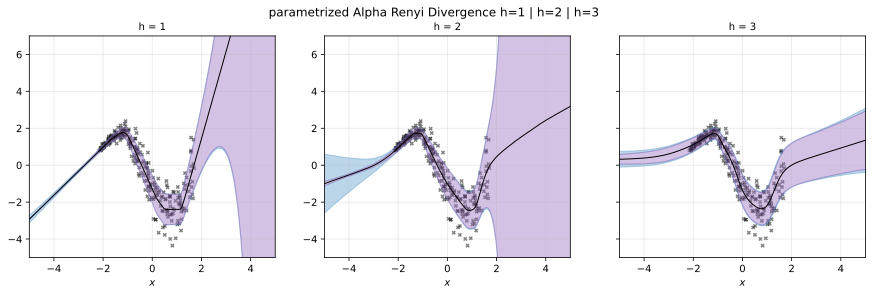

AIC for layers = 1 is: 1131.9235909066883
BIC for layers = 1 is: 3963.178168867934
HQC for layers = 1 is: 2271.4207056707296
LLC for layers = 1 is: -476.0764090933117

AIC for layers = 2 is: 82720.70788696886
BIC for layers = 2 is: 229227.56791370973
HQC for layers = 2 is: 141685.43172110216
LLC for layers = 2 is: -487.2921130311382

AIC for layers = 3 is: 162330.17845713065
BIC for layers = 3 is: 448991.1830147889
HQC for layers = 3 is: 277702.8440420212
LLC for layers = 3 is: -477.8215428693576



In [16]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std


losses       = ["KL", "RKL", "JS", "TVL", "TVU", "F", "A", "AR", "aAR"]
losses_names = ["KL Divergence", "Reverse KL Divergence", "Jensen–Shannon Divergence",
                "Total Variation Distance (lower bound)", "Total Variation Distance (upper bound)",
                "Fisher Distance", "Alpha Divergence", "Alpha Renyi Divergence", "parametrized Alpha Renyi Divergence"]
loss2alpha = {"A": 2.75, "AR": 2.0, "aAR": 2.5} 
name = 0
for loss in losses:
  alpha = loss2alpha[loss] if loss in loss2alpha.keys() else 1.0
  num_epochs, batch_size, nb_train = 500, len(x_train), len(x_train) 
  loss_type= loss

  # best_nets stores the networks for the different hidden layer numbers
  best_nets = []
  for num_units in [[100], [100, 200], [100, 200, 100]]: 
    model = BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=num_units, loss_type=loss_type, alpha=alpha)
    net   = BBP_Model_Wrapper2(network=model, learn_rate=1e-2, batch_size=batch_size, no_batches=1)

    fit_loss_train = np.zeros(num_epochs)
    div_loss_train = np.zeros(num_epochs)
    total_loss = np.zeros(num_epochs)

    best_net, best_loss = None, float('inf')

    for i in range(num_epochs):
        
        fit_loss, div_loss = net.fit(x_train, y_train, no_samples = 20)
        fit_loss_train[i] += fit_loss.cpu().data.numpy()
        div_loss_train[i] += div_loss.cpu().data.numpy()
        
        total_loss[i] = fit_loss_train[i] + div_loss_train[i]
        
        if fit_loss < best_loss:
            best_loss = fit_loss
            best_net = copy.deepcopy(net)
            
        if i % 100 == 0 or i == num_epochs - 1:
            print("Epoch: {0}/{1}, Fit loss = {2}, {3} loss = {4}".format(
                  i+1,num_epochs, fit_loss_train[i], loss_type, div_loss_train[i]))
            samples = []
            for i in range(100):
                preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
                samples.append(preds.cpu().data.numpy()[:, 0])

    train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
    # test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

    train_loglik = train_losses.cpu().data.numpy().mean() + np.log(y_std)
    # test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

    print("Train RMSE = ", train_rmse)
    print("Train Log-likelihood = ", train_loglik)
    # print("test loglike:", test)
    #train_rmses.append(y_stds*train_rmse)
    #test_rmses.append(y_stds*test_rmse)
    best_nets.append(copy.deepcopy(best_net))
  plot_uncertainty_3row(best_nets, x_train, y_train, y_std, y_mean, losses_names[name])

  # convert x_train to cuda for the predictions
  x_for_pred = to_variable(var=(x_train,), cuda=True)[0]

  for i in range(len(best_nets)):
    p = sum([x.numel() for x in best_nets[i].network.parameters()])
    y_pred, loss_pred = best_nets[0].network.forward(x_for_pred)
    y_pred = y_pred.cpu().detach().numpy().astype(float)
    print("AIC for layers =", i+1, "is:", aic(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("BIC for layers =", i+1, "is:", bic(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("HQC for layers =", i+1, "is:", hqc(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("LLC for layers =", i+1, "is:", llc(y_train.flatten().astype(float), y_pred[:, 0].flatten()))
    print()
  name += 1

## Test experiments

Epoch: 1/500, Fit loss = 354.8765869140625, KL loss = 1227.7490234375
Epoch: 101/500, Fit loss = 171.4320831298828, KL loss = 1086.89404296875
Epoch: 201/500, Fit loss = 164.83058166503906, KL loss = 1035.3873291015625
Epoch: 301/500, Fit loss = 162.645751953125, KL loss = 988.457275390625
Epoch: 401/500, Fit loss = 159.43003845214844, KL loss = 938.6194458007812
Epoch: 500/500, Fit loss = 160.0735321044922, KL loss = 887.489990234375
Test RMSE =  -0.33108848333358765
Test Log-likelihood =  [31.650411661601158]
Epoch: 1/500, Fit loss = 355.102783203125, KL loss = 62688.96875
Epoch: 101/500, Fit loss = 173.41085815429688, KL loss = 43302.39453125
Epoch: 201/500, Fit loss = 170.70884704589844, KL loss = 25854.39453125
Epoch: 301/500, Fit loss = 171.0363311767578, KL loss = 12647.5205078125
Epoch: 401/500, Fit loss = 170.8363494873047, KL loss = 5363.21630859375
Epoch: 500/500, Fit loss = 164.25006103515625, KL loss = 2744.703857421875
Test RMSE =  -0.33508485555648804
Test Log-likelihood

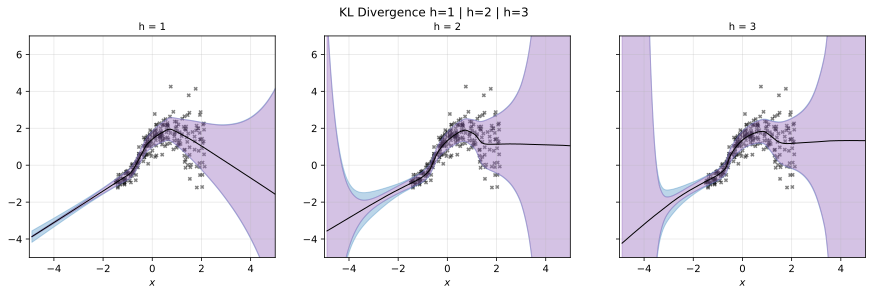

AIC for layers = 1 is: 1459.6206947304454
BIC for layers = 1 is: 4670.765682284927
HQC for layers = 1 is: 2731.150768849791
LLC for layers = 1 is: -148.3793052695545

AIC for layers = 2 is: 83074.11695428411
BIC for layers = 2 is: 249238.88817594663
HQC for layers = 2 is: 148871.0537747583
LLC for layers = 2 is: -133.88304571589248

AIC for layers = 3 is: 162713.4518083118
BIC for layers = 3 is: 487837.8878367758
HQC for layers = 3 is: 291454.2903078282
LLC for layers = 3 is: -94.54819168820974

Epoch: 1/500, Fit loss = 354.8765869140625, RKL loss = 284468.875
Epoch: 101/500, Fit loss = 208.125, RKL loss = 66181.765625
Epoch: 201/500, Fit loss = 210.66624450683594, RKL loss = 31149.052734375
Epoch: 301/500, Fit loss = 216.844970703125, RKL loss = 18830.1171875
Epoch: 401/500, Fit loss = 231.1396942138672, RKL loss = 12932.677734375
Epoch: 500/500, Fit loss = 233.2158966064453, RKL loss = 9631.4541015625
Test RMSE =  -0.44424018263816833
Test Log-likelihood =  [8.848547037577719]
Epoch:

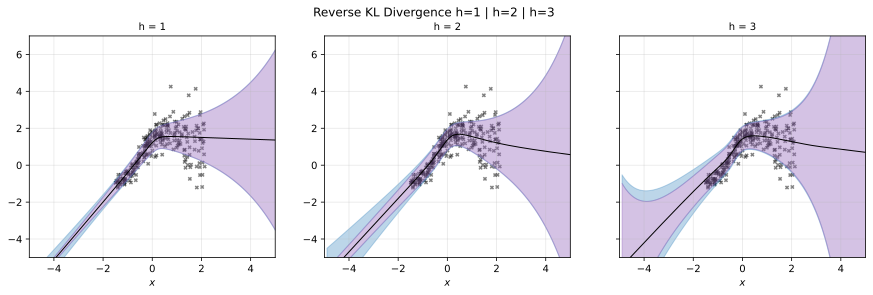

AIC for layers = 1 is: 1716.0126784113415
BIC for layers = 1 is: 4927.157665965823
HQC for layers = 1 is: 2987.5427525306873
LLC for layers = 1 is: 108.01267841134157

AIC for layers = 2 is: 83221.18096807008
BIC for layers = 2 is: 249385.9521897326
HQC for layers = 2 is: 149018.11778854427
LLC for layers = 2 is: 13.180968070085305

AIC for layers = 3 is: 163015.40317877047
BIC for layers = 3 is: 488139.83920723444
HQC for layers = 3 is: 291756.24167828687
LLC for layers = 3 is: 207.40317877046243

Epoch: 1/500, Fit loss = 354.8765869140625, JS loss = 35126.2578125
Epoch: 101/500, Fit loss = 193.8402862548828, JS loss = 8108.283203125
Epoch: 201/500, Fit loss = 194.77560424804688, JS loss = 3882.79345703125
Epoch: 301/500, Fit loss = 206.57266235351562, JS loss = 2450.443359375
Epoch: 401/500, Fit loss = 194.6527557373047, JS loss = 1793.82666015625
Epoch: 500/500, Fit loss = 188.6809539794922, JS loss = 1446.35693359375
Test RMSE =  -0.48463788628578186
Test Log-likelihood =  [48.8419

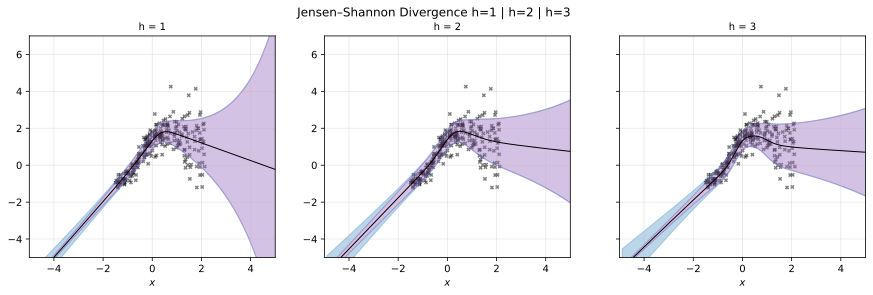

AIC for layers = 1 is: 1747.0525015918515
BIC for layers = 1 is: 4958.197489146332
HQC for layers = 1 is: 3018.582575711197
LLC for layers = 1 is: 139.05250159185152

AIC for layers = 2 is: 83224.30243114723
BIC for layers = 2 is: 249389.07365280975
HQC for layers = 2 is: 149021.23925162142
LLC for layers = 2 is: 16.30243114722788

AIC for layers = 3 is: 162991.10220453574
BIC for layers = 3 is: 488115.53823299974
HQC for layers = 3 is: 291731.94070405216
LLC for layers = 3 is: 183.1022045357246

Epoch: 1/500, Fit loss = 354.8765869140625, TVL loss = 0.019990401342511177
Epoch: 101/500, Fit loss = 162.2996826171875, TVL loss = 0.019999999552965164
Epoch: 201/500, Fit loss = 155.4995880126953, TVL loss = 0.019999999552965164
Epoch: 301/500, Fit loss = 153.0664520263672, TVL loss = 0.019999999552965164
Epoch: 401/500, Fit loss = 151.584716796875, TVL loss = 0.019999999552965164
Epoch: 500/500, Fit loss = 148.45973205566406, TVL loss = 0.019999999552965164
Test RMSE =  -0.3034307956695556

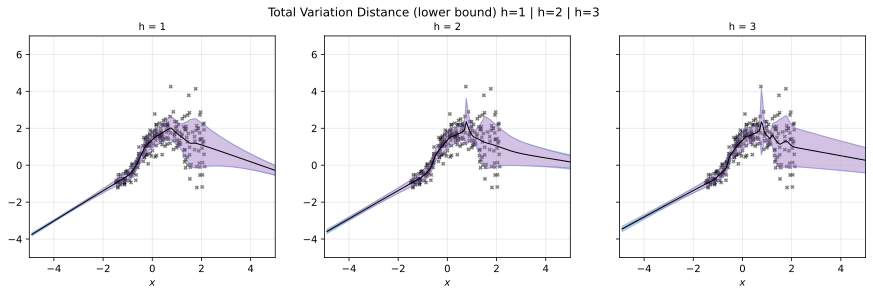

AIC for layers = 1 is: 1467.0573754215293
BIC for layers = 1 is: 4678.202362976011
HQC for layers = 1 is: 2738.587449540875
LLC for layers = 1 is: -140.94262457847069

AIC for layers = 2 is: 83054.60179653269
BIC for layers = 2 is: 249219.3730181952
HQC for layers = 2 is: 148851.53861700688
LLC for layers = 2 is: -153.39820346731676

AIC for layers = 3 is: 162672.31600555457
BIC for layers = 3 is: 487796.7520340186
HQC for layers = 3 is: 291413.154505071
LLC for layers = 3 is: -135.6839944454343

Epoch: 1/500, Fit loss = 354.8765869140625, TVU loss = 605.5392456054688
Epoch: 101/500, Fit loss = 163.8507843017578, TVU loss = 675.91259765625
Epoch: 201/500, Fit loss = 157.5279998779297, TVU loss = 677.478759765625
Epoch: 301/500, Fit loss = 154.3644561767578, TVU loss = 676.81201171875
Epoch: 401/500, Fit loss = 154.48243713378906, TVU loss = 674.9285888671875
Epoch: 500/500, Fit loss = 152.6448974609375, TVU loss = 673.27734375
Test RMSE =  -0.36689016222953796
Test Log-likelihood =  [2

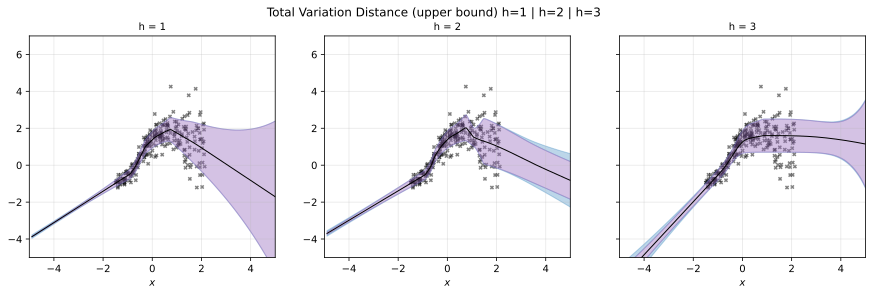

AIC for layers = 1 is: 1493.39511316195
BIC for layers = 1 is: 4704.540100716431
HQC for layers = 1 is: 2764.925187281295
LLC for layers = 1 is: -114.60488683805018

AIC for layers = 2 is: 83082.24814977661
BIC for layers = 2 is: 249247.01937143915
HQC for layers = 2 is: 148879.18497025082
LLC for layers = 2 is: -125.75185022338152

AIC for layers = 3 is: 162692.53567133535
BIC for layers = 3 is: 487816.97169979935
HQC for layers = 3 is: 291433.3741708518
LLC for layers = 3 is: -115.46432866464771

Epoch: 1/500, Fit loss = 354.8765869140625, F loss = 1690.42626953125
Epoch: 101/500, Fit loss = 172.0252227783203, F loss = 1488.529296875
Epoch: 201/500, Fit loss = 166.80458068847656, F loss = 1424.6434326171875
Epoch: 301/500, Fit loss = 164.02325439453125, F loss = 1377.0975341796875
Epoch: 401/500, Fit loss = 159.95372009277344, F loss = 1328.8494873046875
Epoch: 500/500, Fit loss = 160.7394256591797, F loss = 1275.779052734375
Test RMSE =  -0.3240126669406891
Test Log-likelihood =  [3

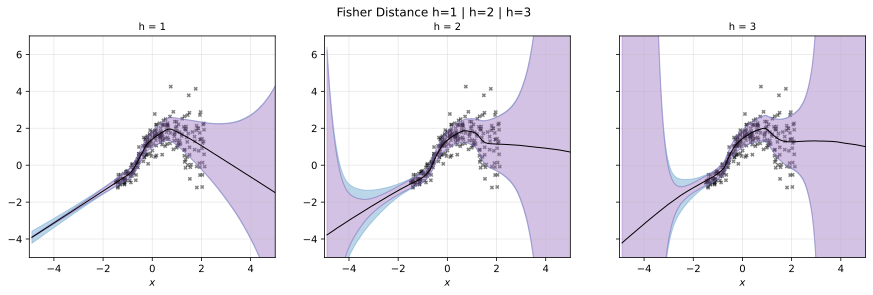

AIC for layers = 1 is: 1449.8266384925041
BIC for layers = 1 is: 4660.971626046985
HQC for layers = 1 is: 2721.3567126118496
LLC for layers = 1 is: -158.17336150749588

AIC for layers = 2 is: 83076.61693784823
BIC for layers = 2 is: 249241.38815951077
HQC for layers = 2 is: 148873.55375832244
LLC for layers = 2 is: -131.38306215176362

AIC for layers = 3 is: 162703.58185181802
BIC for layers = 3 is: 487828.017880282
HQC for layers = 3 is: 291444.42035133444
LLC for layers = 3 is: -104.41814818197406

Epoch: 1/500, Fit loss = 354.8765869140625, A loss = 28406.5625
Epoch: 101/500, Fit loss = 194.23422241210938, A loss = 7803.6884765625
Epoch: 201/500, Fit loss = 195.3862762451172, A loss = 4027.906005859375
Epoch: 301/500, Fit loss = 209.2122344970703, A loss = 2696.7734375
Epoch: 401/500, Fit loss = 194.9203338623047, A loss = 2072.0791015625
Epoch: 500/500, Fit loss = 189.2230682373047, A loss = 1739.826904296875
Test RMSE =  -0.4581000804901123
Test Log-likelihood =  [44.5774250588179

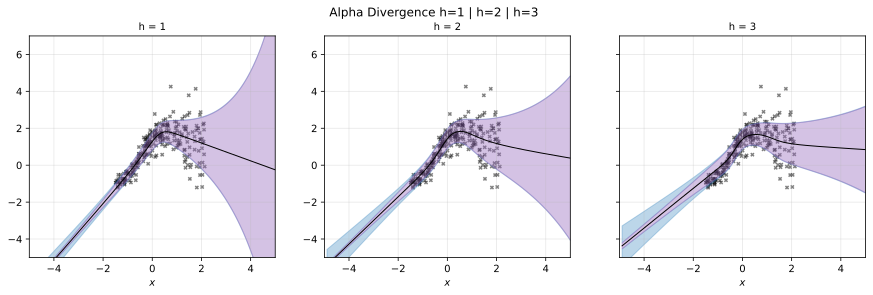

AIC for layers = 1 is: 1782.7021056339493
BIC for layers = 1 is: 4993.84709318843
HQC for layers = 1 is: 3054.2321797532945
LLC for layers = 1 is: 174.70210563394923

AIC for layers = 2 is: 83245.75195822836
BIC for layers = 2 is: 249410.52317989088
HQC for layers = 2 is: 149042.68877870255
LLC for layers = 2 is: 37.75195822835251

AIC for layers = 3 is: 163017.25879839447
BIC for layers = 3 is: 488141.69482685847
HQC for layers = 3 is: 291758.0972979109
LLC for layers = 3 is: 209.25879839446927

Epoch: 1/500, Fit loss = 354.8765869140625, AR loss = 1289.32958984375
Epoch: 101/500, Fit loss = 171.4352569580078, AR loss = 1148.2685546875
Epoch: 201/500, Fit loss = 164.85140991210938, AR loss = 1096.339599609375
Epoch: 301/500, Fit loss = 162.70416259765625, AR loss = 1048.4346923828125
Epoch: 401/500, Fit loss = 159.40957641601562, AR loss = 997.250732421875
Epoch: 500/500, Fit loss = 160.0729522705078, AR loss = 944.318115234375
Test RMSE =  -0.33051010966300964
Test Log-likelihood =  

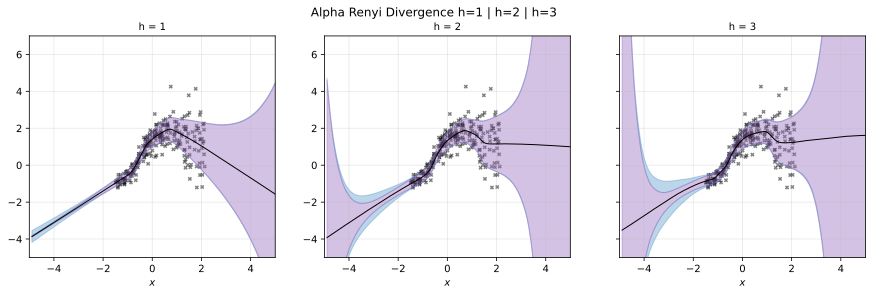

AIC for layers = 1 is: 1462.0735165246979
BIC for layers = 1 is: 4673.218504079179
HQC for layers = 1 is: 2733.6035906440434
LLC for layers = 1 is: -145.9264834753022

AIC for layers = 2 is: 83073.83349221876
BIC for layers = 2 is: 249238.60471388127
HQC for layers = 2 is: 148870.77031269294
LLC for layers = 2 is: -134.16650778123932

AIC for layers = 3 is: 162713.1715790407
BIC for layers = 3 is: 487837.6076075047
HQC for layers = 3 is: 291454.0100785571
LLC for layers = 3 is: -94.82842095930815

Epoch: 1/500, Fit loss = 354.8765869140625, aAR loss = 3448.67236328125
Epoch: 101/500, Fit loss = 176.78025817871094, aAR loss = 2844.84619140625
Epoch: 201/500, Fit loss = 178.03802490234375, aAR loss = 2551.0390625
Epoch: 301/500, Fit loss = 171.65966796875, aAR loss = 2347.66064453125
Epoch: 401/500, Fit loss = 165.8349151611328, aAR loss = 2164.5
Epoch: 500/500, Fit loss = 163.33700561523438, aAR loss = 1997.112060546875
Test RMSE =  -0.37895694375038147
Test Log-likelihood =  [66.481832

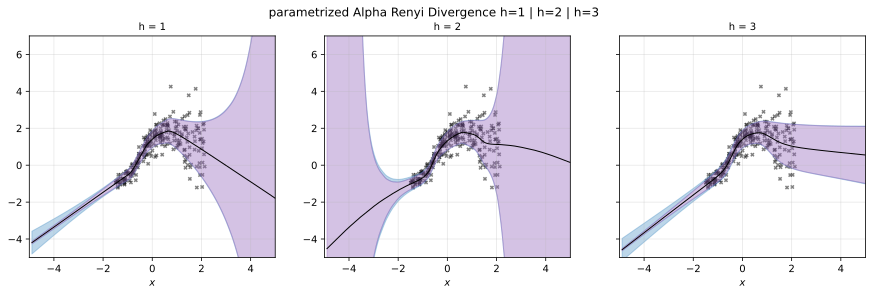

AIC for layers = 1 is: 1435.3404691173453
BIC for layers = 1 is: 4646.485456671827
HQC for layers = 1 is: 2706.870543236691
LLC for layers = 1 is: -172.6595308826547

AIC for layers = 2 is: 83119.88926192177
BIC for layers = 2 is: 249284.6604835843
HQC for layers = 2 is: 148916.82608239597
LLC for layers = 2 is: -88.11073807823226

AIC for layers = 3 is: 162761.21028326638
BIC for layers = 3 is: 487885.6463117304
HQC for layers = 3 is: 291502.0487827828
LLC for layers = 3 is: -46.78971673361771



In [17]:
np.random.seed(2)
no_points_train, no_points_test = 400, 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points_train+no_points_test)[:, None]
x.sort(axis=0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points_train+no_points_test)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points_train+no_points_test)), C)[:, None]

mask     = np.random.random(size=len(x)) > 0.5
not_mask = np.logical_not(mask)
x_train, y_train = x[mask], y[mask]
x_test, y_test   = x[not_mask], y[not_mask]
y = (y - y.mean())
# take only the central part (II)
x_train = x_train[75:325]
x_test  = x_test # [75:325]

y_mean = y_train[75:325].mean()
y_std = y_train[75:325].var()**0.5
y_train = (y_train[75:325] - y_mean)/y_std
# standardize the test data as well
y_test =  (y_test - y_mean)/y_std

losses       = ["KL", "RKL", "JS", "TVL", "TVU", "F", "A", "AR", "aAR"]
losses_names = ["KL Divergence", "Reverse KL Divergence", "Jensen–Shannon Divergence",
                "Total Variation Distance (lower bound)", "Total Variation Distance (upper bound)",
                "Fisher Distance", "Alpha Divergence", "Alpha Renyi Divergence", "parametrized Alpha Renyi Divergence"]
loss2alpha = {"A": 2.75, "AR": 2.0, "aAR": 2.5} 
name = 0
for loss in losses:
  alpha = loss2alpha[loss] if loss in loss2alpha.keys() else 1.0
  num_epochs, batch_size, nb_train = 500, len(x_train), len(x_train) 
  loss_type= loss

  # best_nets stores the networks for the different hidden layer numbers
  best_nets = []
  test_logliks = []
  for num_units in [[100], [100, 200], [100, 200, 100]]: 
    model = BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=num_units, loss_type=loss_type, alpha=alpha)
    net   = BBP_Model_Wrapper2(network=model, learn_rate=1e-2, batch_size=batch_size, no_batches=1)

    fit_loss_train = np.zeros(num_epochs)
    div_loss_train = np.zeros(num_epochs)
    total_loss = np.zeros(num_epochs)

    best_net, best_loss = None, float('inf')

    for i in range(num_epochs):

        fit_loss, div_loss = net.fit(x_train, y_train, no_samples = 20)
        fit_loss_train[i] += fit_loss.cpu().data.numpy()
        div_loss_train[i] += div_loss.cpu().data.numpy()
        
        total_loss[i] = fit_loss_train[i] + div_loss_train[i]
        
        if fit_loss < best_loss:
            best_loss = fit_loss
            best_net = copy.deepcopy(net)
            
        if i % 100 == 0 or i == num_epochs - 1:
            print("Epoch: {0}/{1}, Fit loss = {2}, {3} loss = {4}".format(
                  i+1,num_epochs, fit_loss_train[i], loss_type, div_loss_train[i]))
            samples = []
            for i in range(100):
                preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
                samples.append(preds.cpu().data.numpy()[:, 0])

    # train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
    test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

    # train_loglik = train_losses.cpu().data.numpy().mean() + np.log(y_std)
    test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_std)))

    print("Test RMSE = ", test_rmse)
    print("Test Log-likelihood = ", test_logliks)
    # print("test loglike:", test)
    #train_rmses.append(y_stds*train_rmse)
    #test_rmses.append(y_stds*test_rmse)
    best_nets.append(copy.deepcopy(best_net))
  plot_uncertainty_3row(best_nets, x_test, y_test, y_std, y_mean, losses_names[name])

  # convert x_train to cuda for the predictions
  x_for_pred = to_variable(var=(x_test,), cuda=True)[0]

  for i in range(len(best_nets)):
    p = sum([x.numel() for x in best_nets[i].network.parameters()])
    y_pred, loss_pred = best_nets[0].network.forward(x_for_pred)
    y_pred = y_pred.cpu().detach().numpy().astype(float)
    print("AIC for layers =", i+1, "is:", aic(y_test.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("BIC for layers =", i+1, "is:", bic(y_test.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("HQC for layers =", i+1, "is:", hqc(y_test.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("LLC for layers =", i+1, "is:", llc(y_test.flatten().astype(float), y_pred[:, 0].flatten()))
    print()
  name += 1